In [165]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import math
from scipy import stats
from astropy.stats import RipleysKEstimator


def PlotSingleDistances(folder, extension, ax, log=False):
    '''Plots boxplot of distance to closest cell give ImageJ data, with or without log transformation'''
    times = GetTimes(folder, extension)
    
    file_frame = pd.concat(Generate_dfs(folder, extension, times))
    
    if log == True:
        logs = []
        for length in file_frame['Length']:
            logs.append(math.log(length))
        file_frame['Log Lengths'] = logs    
        
        b = sns.boxplot(x='Time', y='Log Lengths', data=file_frame , ax=ax)
        ax.set_ylim(-1.7,1.6)
    else:
        b = sns.boxplot(x = 'Time', y = 'Length', data=file_frame, ax=ax)
        ax.set_ylim(0,4.5)
    
    

def GetTimes(folder, extension):
    '''Takes in a folder and extension in correct format and returns list of times'''
    filenames = glob.glob("msresist/data/Distances/" + folder + "/*.csv")
    filename_prefix = "msresist/data/Distances/" + folder + "/Results_" + extension + "_"
    filename_suffix = ".csv"
    
    times = []
    for file in filenames:
        time = int(file[len(filename_prefix):-len(filename_suffix)])
        times.append(time)
    times = sorted(times)
    return times

def Generate_dfs(folder, extension, times):
    '''Generates dfs of the data at each time point with an added column for time'''
    file_list = []
    for time in times:
        file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + extension + "_" + str(time) + ".csv")
        file['Time'] = time
        file_list.append(file)
    return file_list

def Calculate_closest(file_list, n=(1,3)):
    '''Calculates distances to nearby cells and returns as dataframe ready to plot'''
    distances_by_time = pd.DataFrame()
    for idx, file in enumerate(file_list):
        distances_df = pd.DataFrame()
        points = file.loc[:,'X':'Y']
        #shortest_n_distances_lists = []
        shortest_n_distances = []
        for origin_cell in np.arange(points.shape[0]):
            distances = []
            x1,y1 = points.iloc[origin_cell, :]
            for other_cell in np.arange(points.shape[0]):
                x2,y2 = points.iloc[other_cell, :]
                distance = abs(math.sqrt((x2-x1)**2 + (y2-y1)**2))
                distances.append(distance)
            distances = sorted(distances)
            #shortest_n_distances_lists.append(distances[1:(n+1)])
            shortest_n_distances.extend(distances[n[0]:(n[1]+1)])
        distances_df['Distances'] = shortest_n_distances
        distances_df['Time'] = idx*3
        distances_by_time = distances_by_time.append(distances_df)
    return distances_by_time
                           
def PlotClosestN(folder, extension, ax, log=False, cells=(1,3)):
    '''Plots specified range of nearby cells as boxplots with or without log transformation'''
    times = GetTimes(folder, extension)
    
    file_list = Generate_dfs(folder, extension, times)
    
    plotting_frame = Calculate_closest(file_list, cells)
    
    if log == True:
        logs = []
        for length in plotting_frame['Distances']:
            logs.append(math.log(length))
        plotting_frame['Log Distances'] = logs    
        
        b = sns.boxplot(x='Time', y='Log Distances', data=plotting_frame , ax=ax)
        ax.set_ylim(-2, 2.3)
    else:
        b = sns.boxplot(x='Time', y='Distances', data=plotting_frame, ax=ax)
        ax.set_ylim(0, 8)

        

def PlotNhrsdistances(folder, mutants, treatments, replicates, ax, log=False, logmean=False, cells=(1,3)):
    '''Creates either raw/log grouped boxplot or log pointplot for distances to cells depending on log and logmean variables for range of nearby cells'''
    dfs = []
    for mutant in mutants:
        mut_frames = []
        for treatment in treatments:
            for replicate in range(1,replicates + 1):
                if replicate != 1:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + str(replicate) + ".csv")
                else:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + ".csv")
                distances = calculatedistances(file, mutant, treatment, replicate, cells)
                mut_frames.append(distances)
        mut_frame = pd.concat(mut_frames)
        dfs.append(mut_frame)
        
    to_plot = pd.concat(dfs)
    if log == True:
        logs = []
        for length in to_plot['Distances']:
            logs.append(math.log(length))
        to_plot['Log Distances'] = logs    
        if logmean == False:
            b = sns.boxplot(x='Mutant', y='Log Distances', hue='Condition', data=to_plot , ax=ax)
        else:
            b = sns.pointplot(x='Mutant', y='Log Distances', hue='Condition', data=to_plot, ci=68, join=False, dodge=.4, ax=ax)
        
    else:
        b = sns.boxplot(x='Mutant', y='Distances', hue='Condition', data=to_plot, ax=ax)
        ax.set_ylim(0,5)
        #b = sns.swarmplot(x='Mutant', y='Distances', hue='Condition', data=to_plot, dodge=True, ax=ax)
                
                
def calculatedistances(file, mutant, treatment, replicate, n=(1,3)):
    '''Calculates distances to range of other cells for a given mutant, treatment, and condition'''
    distances_df = pd.DataFrame()
    points = file.loc[:,'X':'Y']
    shortest_n_distances = []
    for origin_cell in np.arange(points.shape[0]):
        distances = []
        x1,y1 = points.iloc[origin_cell, :]
        for other_cell in np.arange(points.shape[0]):
            x2,y2 = points.iloc[other_cell, :]
            distance = abs(math.sqrt((x2-x1)**2 + (y2-y1)**2))
            distances.append(distance)
        distances = sorted(distances)
        shortest_n_distances.extend(distances[n[0]:(n[1]+1)])
    distances_df['Distances'] = shortest_n_distances
    distances_df['Mutant'] = mutant
    if replicate != 1:
        distances_df['Condition'] = treatment + str(replicate)
    else:
        distances_df['Condition'] = treatment
    return distances_df
    


def Plot_Logmean(folder, mutants, treatments, replicates, ax, vs_count=False, cells=(1,3)):
    dfs = []
    for mutant in mutants:
        mut_frames = []
        for treatment in treatments:
            for replicate in range(1, replicates + 1):
                if replicate != 1:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + str(replicate) + ".csv")
                else:
                    file = pd.read_csv("msresist/data/Distances/" + folder + "/Results_" + mutant + treatment + ".csv")
                distances = calculatedistances_logmean(file, mutant, treatment, replicate, vs_count, cells)
                mut_frames.append(distances)
        mut_frame = pd.concat(mut_frames)
        dfs.append(mut_frame)
        
    to_plot = pd.concat(dfs)
    if vs_count == True:
        b = sns.scatterplot(x='Cells', y='Log_Mean_Distances', hue='Condition', style='Condition', data=to_plot, ax=ax)
        #for line in range(0, to_plot.shape[0]):
             #b.text(to_plot.Cells.iloc[line], to_plot.Log_Mean_Distances.iloc[line], to_plot.Mutant.iloc[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        b = sns.pointplot(x="Mutant", y='Log_Mean_Distances', hue='Condition', data=to_plot, ci=68, join=False, dodge=.25, ax=ax)
    
def calculatedistances_logmean(file, mutant, treatment, replicate, vs_count, n=(1,3)):
    points = file.loc[:,'X':'Y']
    shortest_n_distances = []
    for origin_cell in np.arange(points.shape[0]):
        distances = []
        x1,y1 = points.iloc[origin_cell, :]
        for other_cell in np.arange(points.shape[0]):
            x2,y2 = points.iloc[other_cell, :]
            distance = abs(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))
            distances.append(distance)
        distances = sorted(distances)
        shortest_n_distances.extend(distances[n[0]:(n[1] + 1)])
    logs = []
    for length in shortest_n_distances:
        logs.append(math.log(length))
    log_mean = np.mean(logs)
    cell_number = points.shape[0]
    condition = treatment
    if vs_count == True:
        distances_dict = {'Log_Mean_Distances':[log_mean], 'Cells':[cell_number], 'Condition':[condition], 'Mutant':[mutant]}
    else:
        distances_dict = {'Log_Mean_Distances':[log_mean], 'Mutant':[mutant], 'Condition':[condition]}
    distances_df = pd.DataFrame(distances_dict)
    return distances_df

def PlotRipleysK(folder, mutant, treatments, replicates, average, ax):
    r = np.linspace(0, 5, 500)
    #HiConf, LowConf = ConfidenceKest(r)
    for idx in range(len(treatments)):
        reps = []
        for replicate in range(1, replicates + 1):
            if replicate != 1:
                file = pd.read_csv("msresist/data/Distances/"+folder+"/Results_"+mutant+treatments[idx]+str(replicate)+".csv")
            else:
                file = pd.read_csv("msresist/data/Distances/"+folder+"/Results_"+mutant+treatments[idx]+".csv")
            points = file.loc[:, "X":"Y"].values
            reps.append(points)
        Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)
        axs[idx].plot(r, Kest.poisson(r))
        axs[idx].set_title(treatments[idx])
        leg = ['poisson']
        for replicate in range(1, replicates + 1):
            leg.append(str(replicate))
        if average == True:
            Kests = []
            for rep in reps:
                Est = Kest(data=rep, radii=r, mode='ripley')
                Kests.append(Est)
            avg_kest = np.mean(np.vstack(Kests), axis=0)
            axs[idx].plot(r, avg_kest)
        else:
            for replicate in range(1, replicates + 1):
                leg.append(str(replicate))
            for rep in reps:
                axs[idx].plot(r, Kest(data=rep, radii=r, mode='ripley'))
                axs[idx].legend(leg)
        #axs[idx].plot(r, HiConf, color='black')
        #axs[idx].plot(r, LowConf, color='black')

                  
'''def ConfidenceKest(radii):
    coords = []
    for i in range(100):
        x = np.random.uniform(low=0, high=14.67, size=(100,1))
        y = np.random.uniform(low=0, high=10.83, size=(100,1))
        both = np.hstack((x,y))
        coords.append(both)
    
    Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)
    Kests = []
    for coord in coords:
        Kests.append(Kest(data=coord, radii=radii, mode='ripley'))
    MaxKest = np.zeros(radii.size)
    MinKest = np.zeros(radii.size)
    for i in range(radii.size):
        max_val = 0
        min_val = np.inf
        for kest in Kests:
            if kest[i] > max_val:
                max_val = kest[i]
            if kest[i] < min_val:
                min_val = kest[i]
        MaxKest[i] = max_val
        MinKest[i] = min_val
    return MaxKest, MinKest'''


"def ConfidenceKest(radii):\n    coords = []\n    for i in range(100):\n        x = np.random.uniform(low=0, high=14.67, size=(100,1))\n        y = np.random.uniform(low=0, high=10.83, size=(100,1))\n        both = np.hstack((x,y))\n        coords.append(both)\n    \n    Kest = RipleysKEstimator(area=158.8761, x_max=14.67, y_max=10.83, x_min=0, y_min=0)\n    Kests = []\n    for coord in coords:\n        Kests.append(Kest(data=coord, radii=radii, mode='ripley'))\n    MaxKest = np.zeros(radii.size)\n    MinKest = np.zeros(radii.size)\n    for i in range(radii.size):\n        max_val = 0\n        min_val = np.inf\n        for kest in Kests:\n            if kest[i] > max_val:\n                max_val = kest[i]\n            if kest[i] < min_val:\n                min_val = kest[i]\n        MaxKest[i] = max_val\n        MinKest[i] = min_val\n    return MaxKest, MinKest"

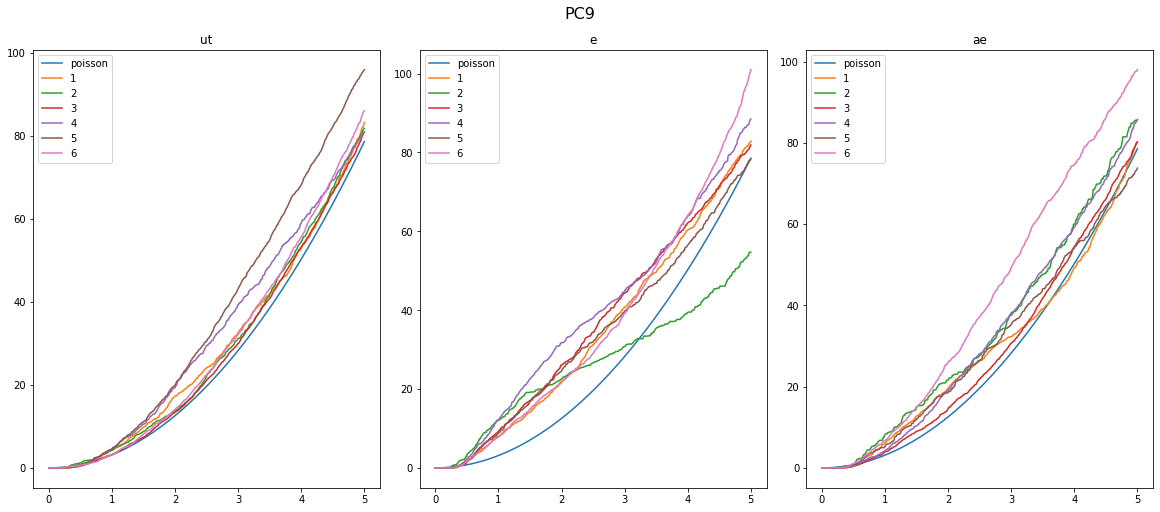

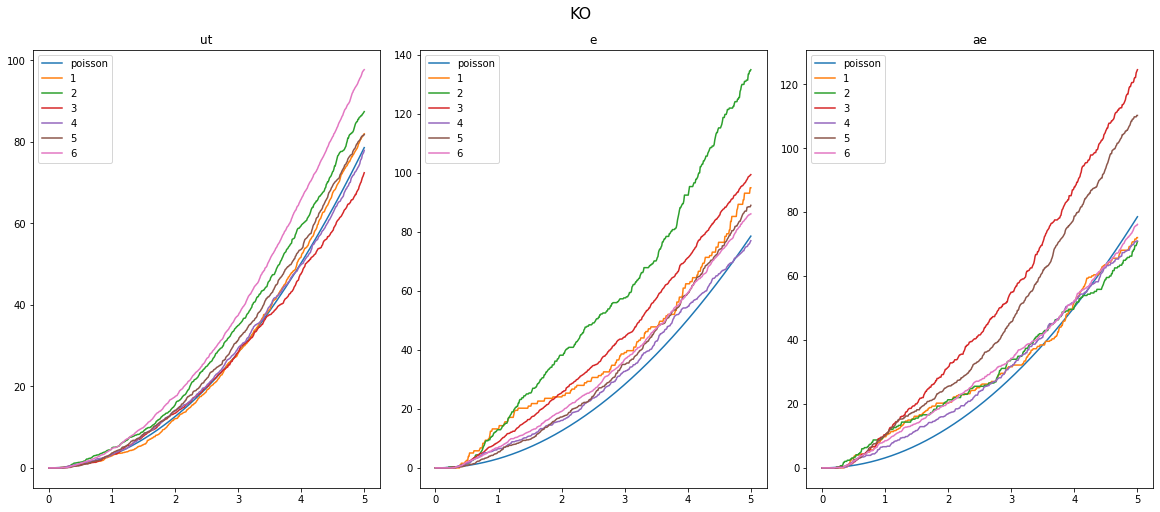

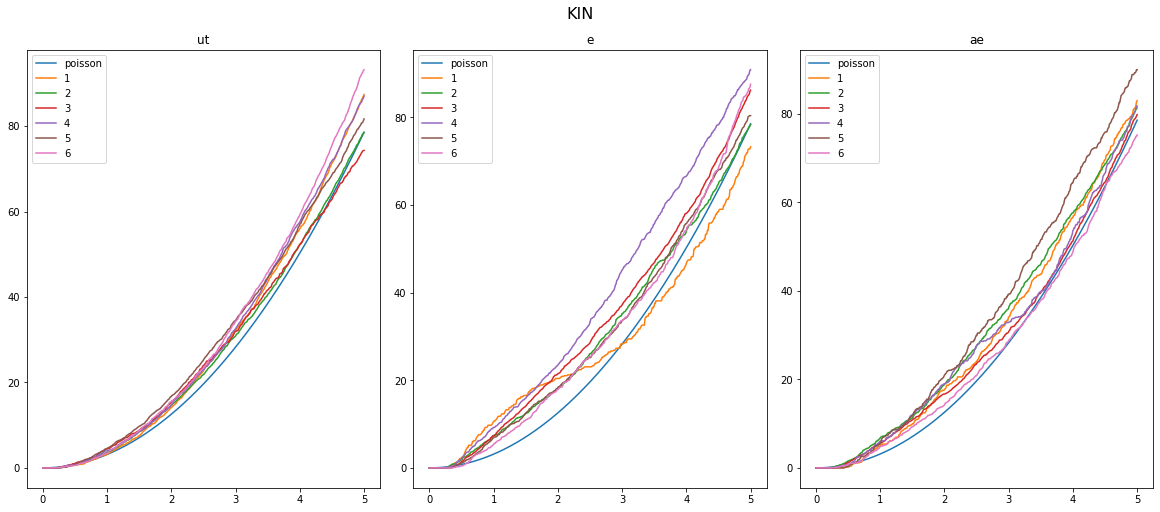

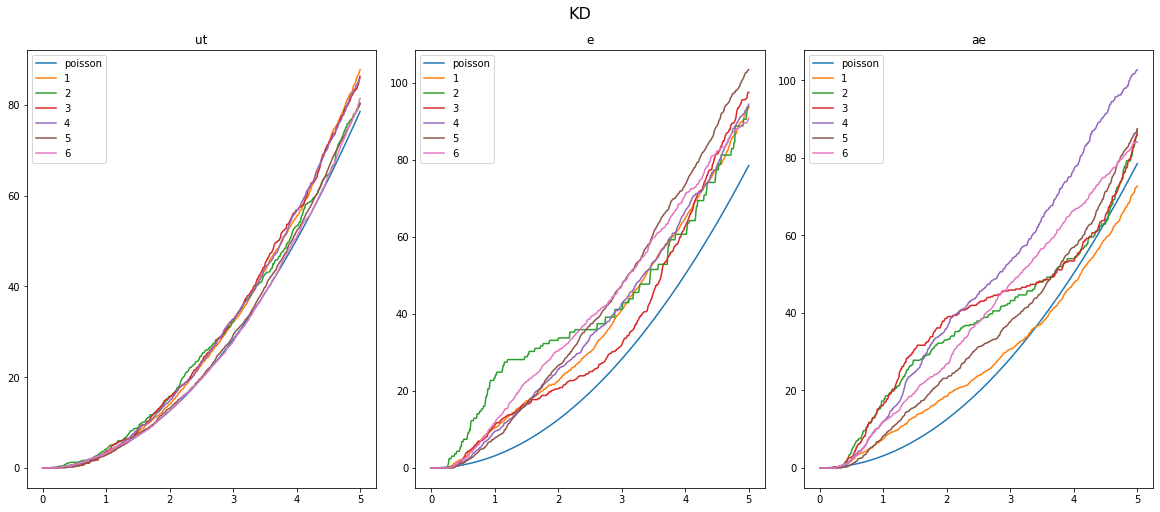

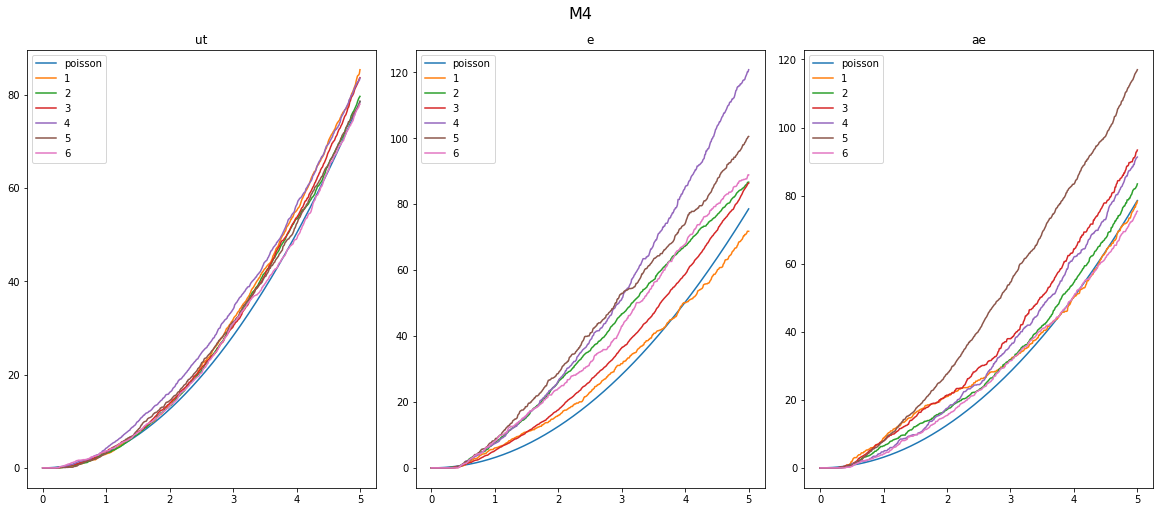

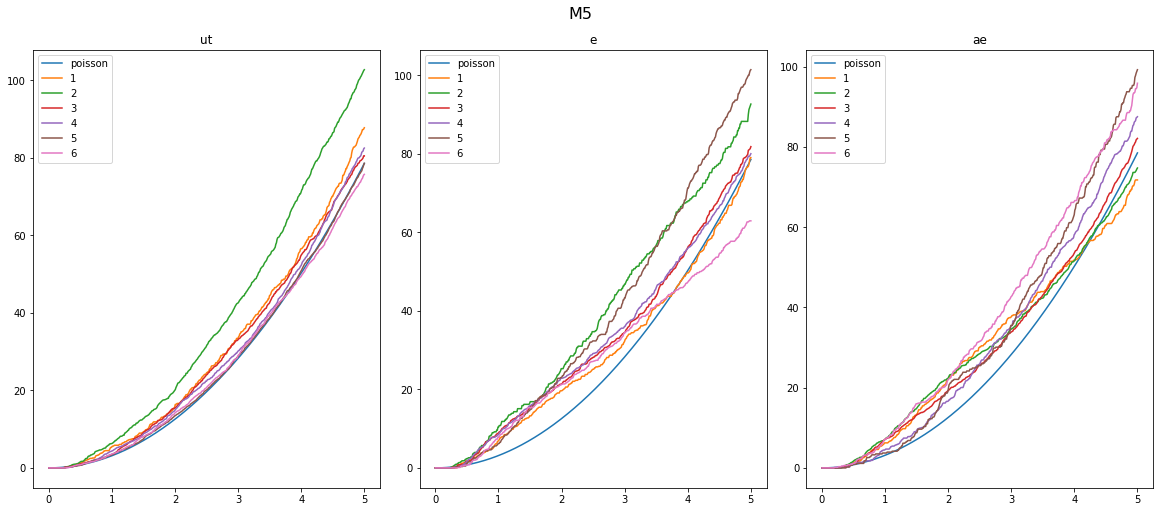

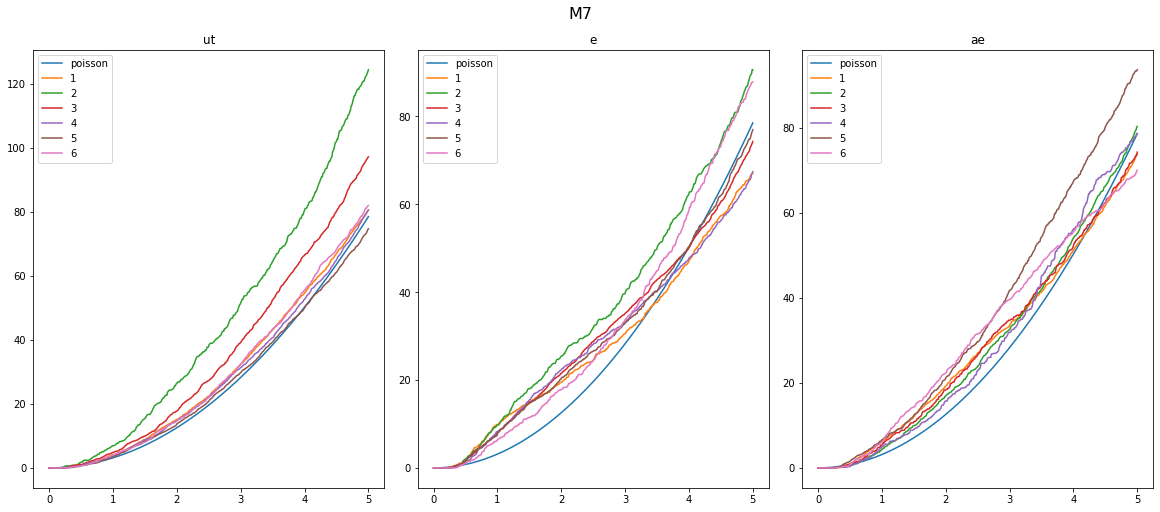

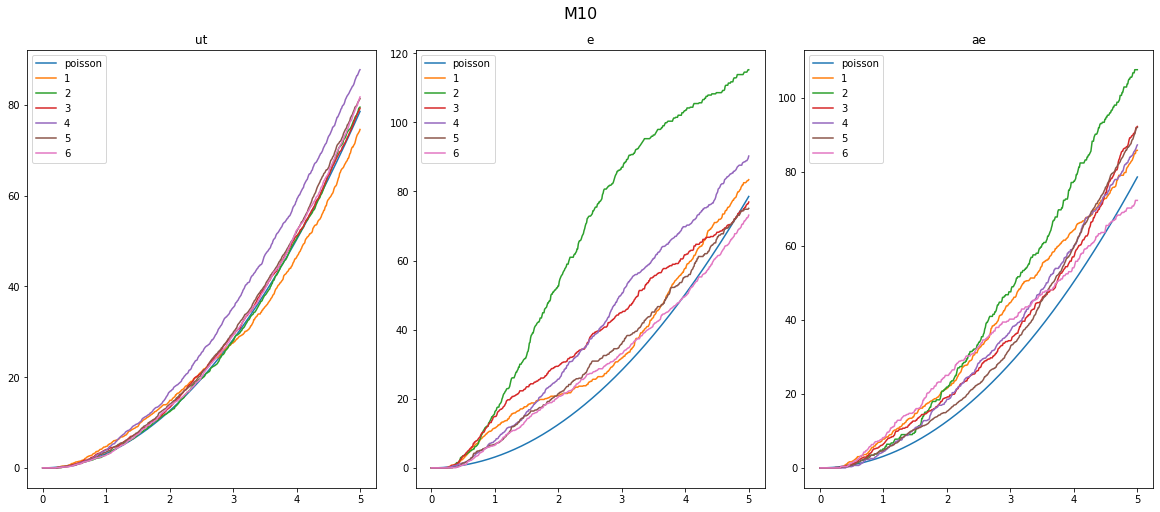

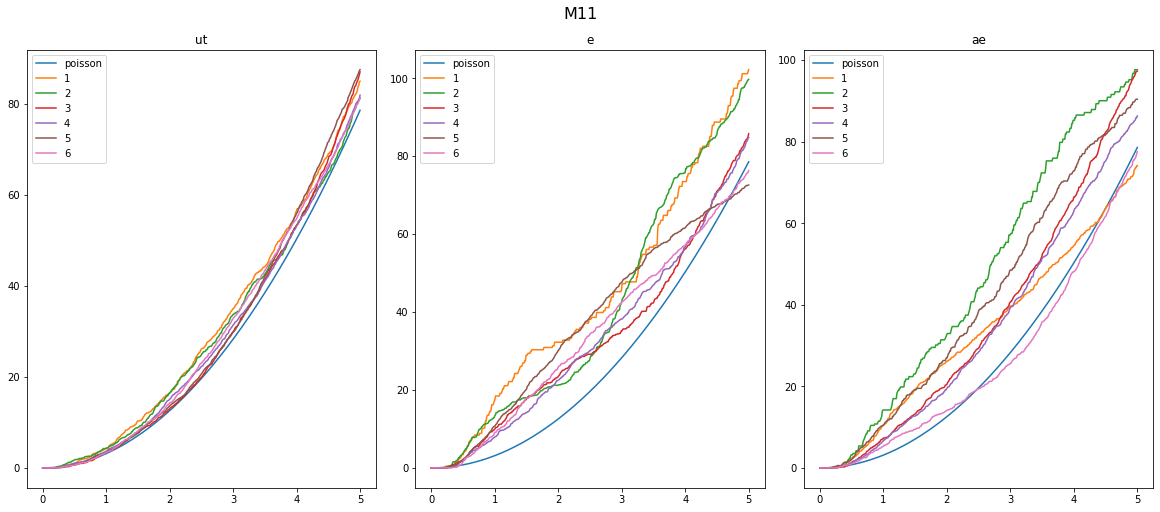

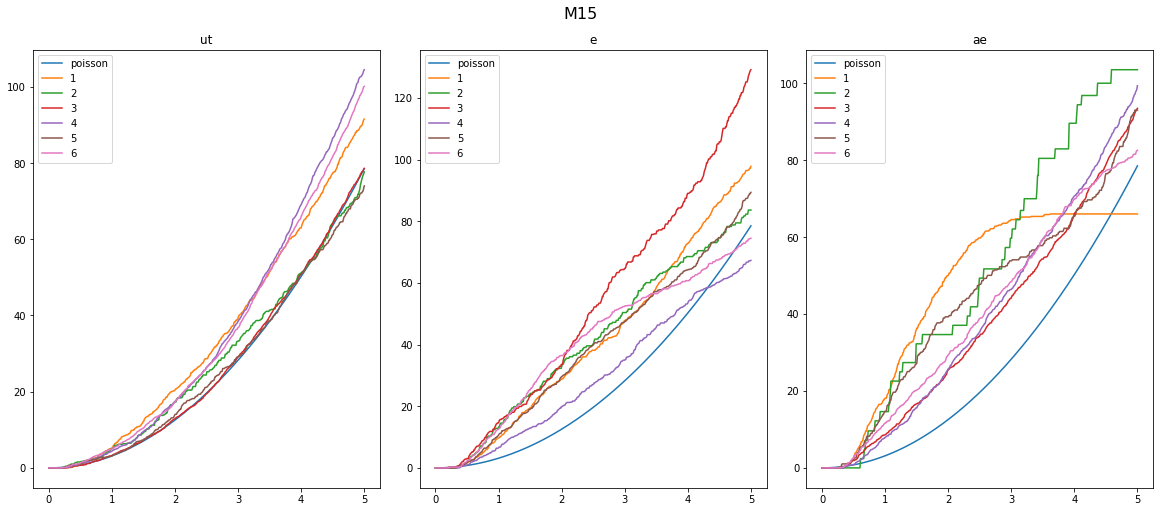

In [167]:
#fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (16, 7))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
for mutant in mutants:
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize = (16, 7), constrained_layout=True)
    PlotRipleysK('48hrs', mutant, treatments, replicates, average=False, ax=axs)
    fig.suptitle(mutant, fontsize=16)

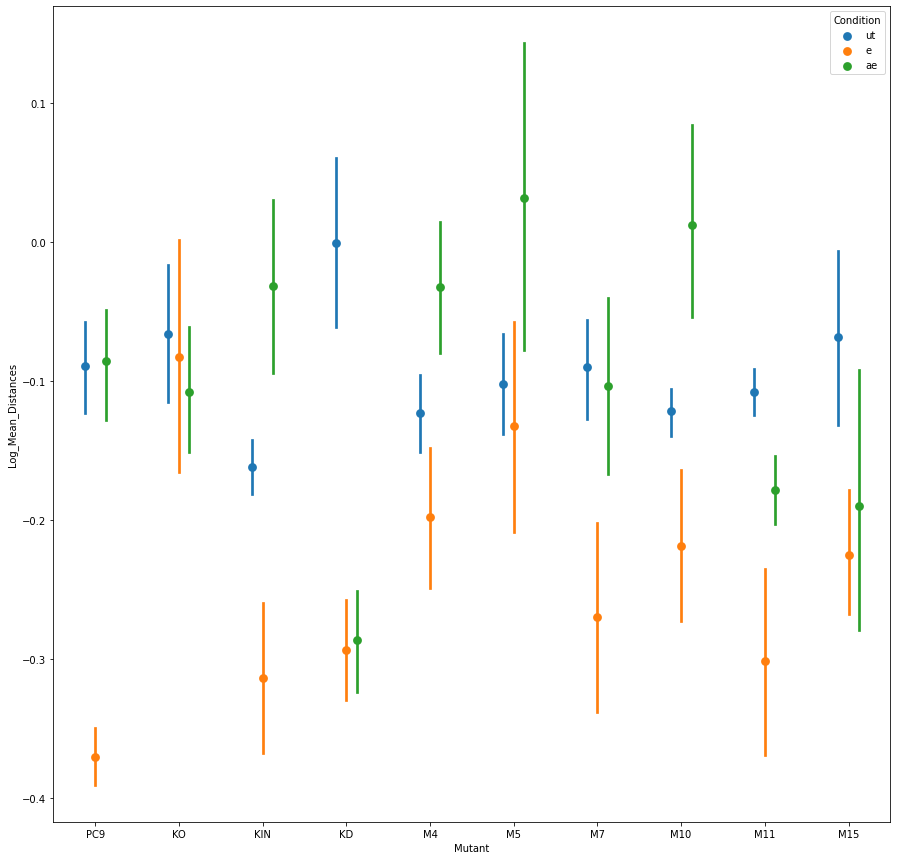

In [127]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,15))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
Plot_Logmean('48hrs', mutants, treatments, replicates, ax, vs_count=False, cells=(2,2))

#fig.savefig("Mutants48hrs_logmean_average")

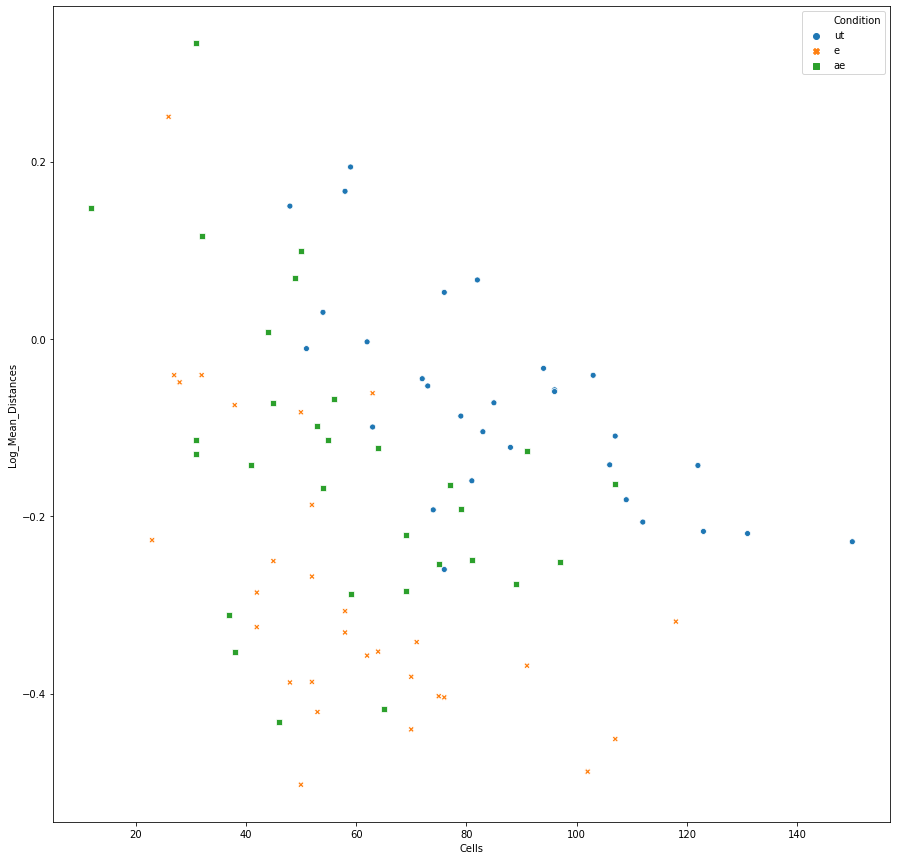

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (15,15))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
Plot_Logmean('48hrs', mutants, treatments, replicates, ax, vs_count=True, cells=(2,2))

#fig.savefig("Mutants48hrs_logmean_average")

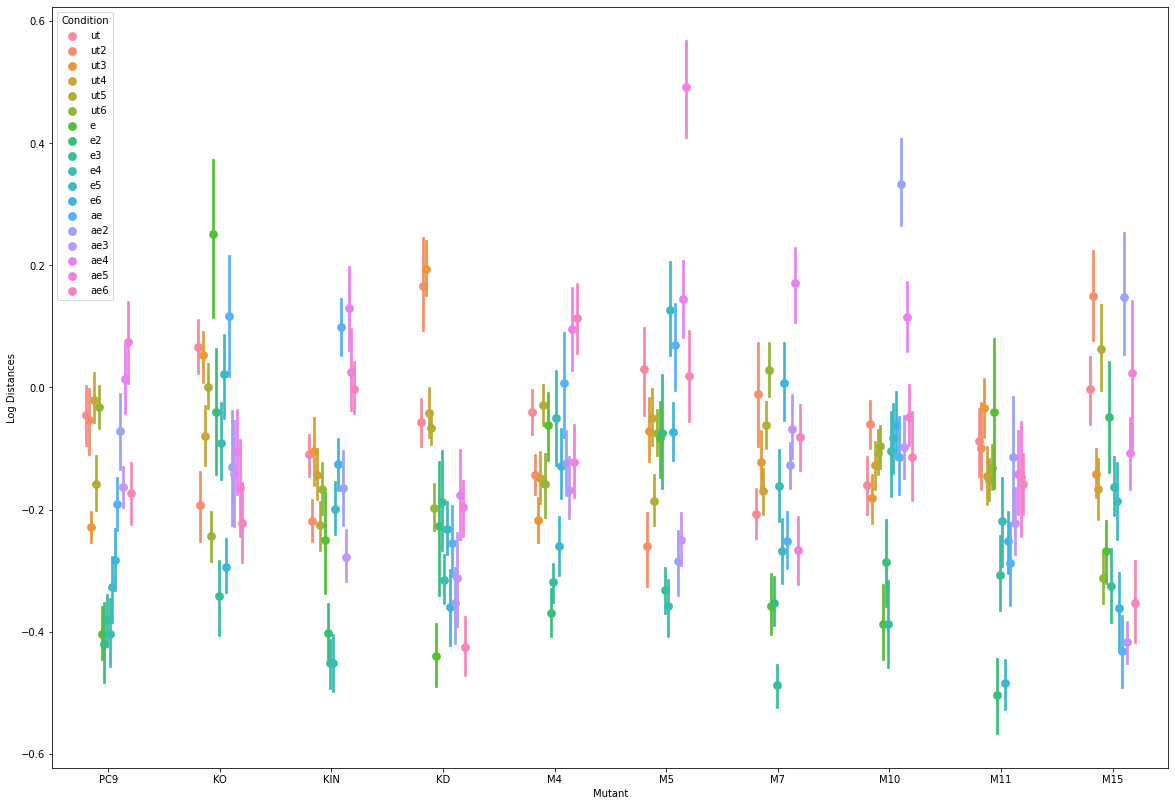

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (20,14))
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
PlotNhrsdistances('48hrs', mutants, treatments, replicates, ax, log=True, logmean=True, cells=(2,2))

fig.savefig("Mutants48hrs_logmean")

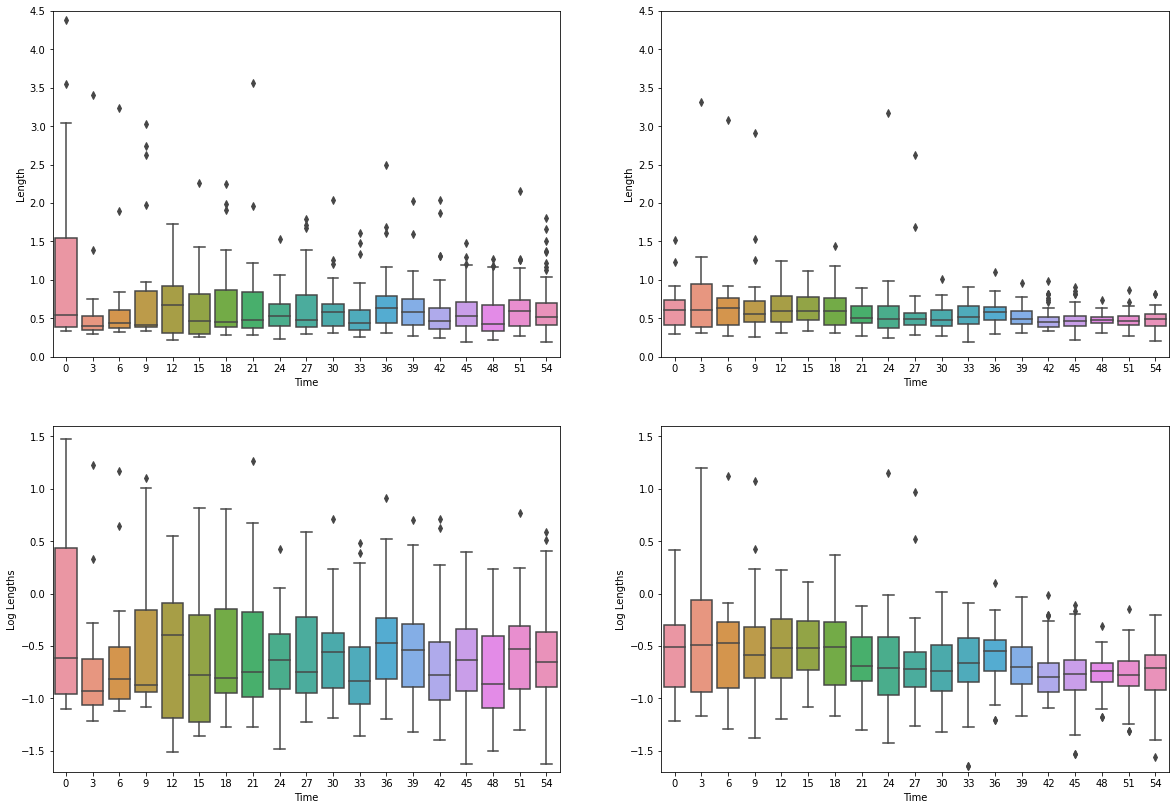

In [80]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,14))
PlotSingleDistances('PC9_UT', 'ut', ax[0,0])
PlotSingleDistances('PC9_E', 'e', ax[0,1])
PlotSingleDistances('PC9_UT', 'ut', ax[1,0], True)
PlotSingleDistances('PC9_E', 'e', ax[1,1], True)


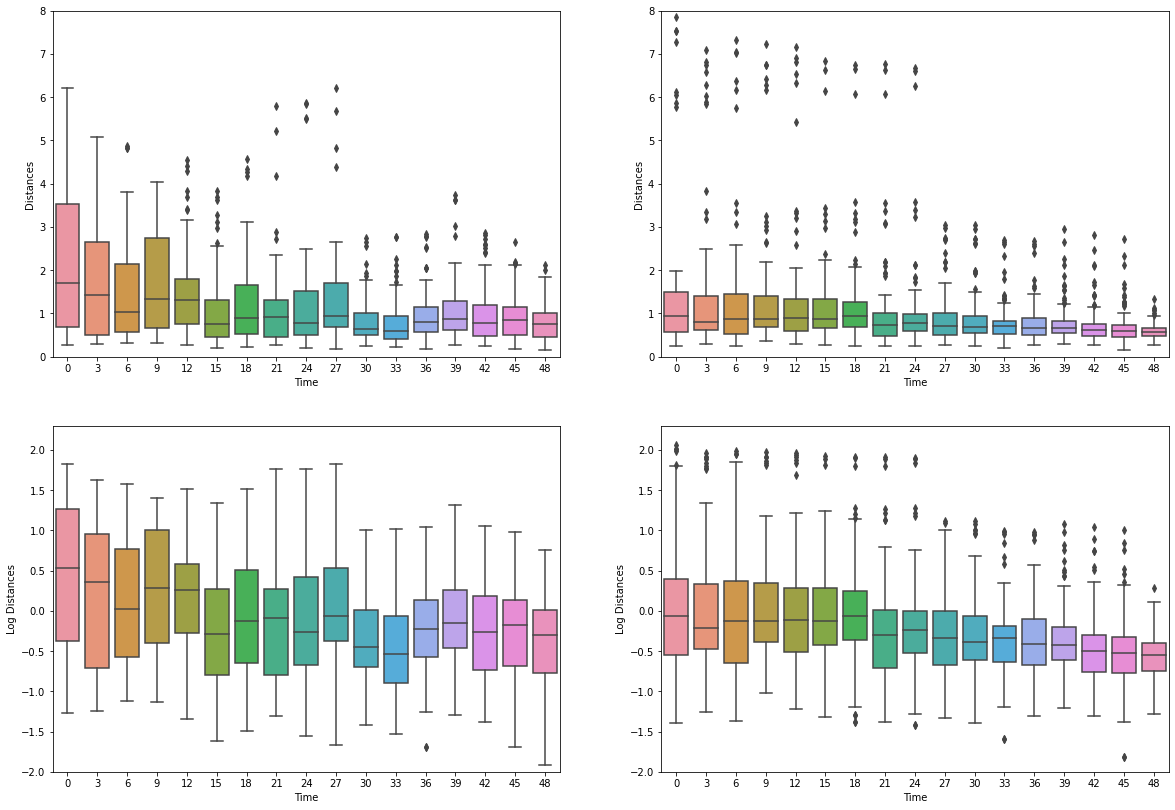

In [74]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (20, 14))
PlotClosestN('C1', 'C1', ax[0,0])
PlotClosestN('F1', 'F1', ax[0,1])
PlotClosestN('C1', 'C1', ax[1,0], True)
PlotClosestN('F1', 'F1', ax[1,1], True)
